# Predicting responstimes with a ReLU neural network - hyper parameter search

In this notebook I evaluate the N-way RNN model with line search on a larger randomly generated hierarchical noise-free concurrency structure. 

For this I implemented
- random search for the hyper-parameters
- automatic generation of random hierarchical concurrency structures

I will first evaluate the random search for acceptable hyper parameters on the diamond structure, then on a 15-transaction hierarchical structure.

## Summary of findings

### Random search on the diamond
With the help of random search I examined the dependence of the validation MSE on the diamond after 1500 iterations on the following parameters: lower_bound_ratio, upper_bound_ratio, tolerance, momentum, l_min, l_max, leaking factor.

I found that the among these the leaking factor has the greatest impact and it should be set to values smaller than $-0.5$. The second largest impact was that of l_max. This had to be set to $-3$ or less. When these parameters were set to values outside these limits, the MSE did not sink to the extreme levels seen in previous experiments. **With the correct settings of these parameters the validation MSE ranged between $10^{-8}$ and $1$ over the 50 training runs.**

I analyzed why the MSE varied over such a large range. My conclusions are that the constellation of the hyper-parameter values and the initialization of the weights are not the cause of these variations, because the MSE kept varying agressively over the runs even when the same (and in a previuos run well-scoring) constellation was used and when the same constellation and weight-initialization were used. After excluding these two the only remaining non-deterministic element of the algorithm is the **random sampling of the training data**, which I now consider **the source of the variation in the success of the algorithm** (though did not prove it experimentally).

### Random search on a 15-transaction structure
I also applied random search to the 15-transaction structure

       (Trx('trx') | Trx('trx') | (Trx('trx') - Trx('trx')) | 
       Trx('trx') | Trx('trx') | Trx('trx') | Trx('trx') | 
       (Trx('trx') - Trx('trx') - Trx('trx')) | 
       Trx('trx') | Trx('trx') | 
       (Trx('trx') - Trx('trx'))
   
which in 50 training attempts could not be trained to better than a $10^{-1}$ validation MSE.

### Why the big variation?
I find the variation of the MSE surprising because the training data is noise-free, so at the global minimum of the MSE over the joint distribution of the inputs the MSE over any sample is minimal as well. As the MSE is a piece-wise quadratic function of the parameters, one would expect that moving to the minimum of the sample MSE leads in just one step to the global minima, if that minima is within the boundaries of the quadratic piece. But if the sample minima is outside the boundary, then it is not related to the global minima, so moving to it makes no sense!

Still why is the path non-deterministic?



In [1]:
from pprint import pprint
from itertools import count
import theano
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from theano import pp
from theano import tensor as T
from theano import function
from theano.ifelse import ifelse
from theano.compile.nanguardmode import NanGuardMode
import numpy as np
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import uniform, geom
from math import log, exp
import random
import operator
import sys
sys.setrecursionlimit(sys.getrecursionlimit()*5)

In [2]:
%matplotlib inline

In [3]:
np.set_printoptions(precision=3, suppress=True)
from FSBGraph import FSBSampler, FSBGraph, Trx

## The N-way RNN model with line search

In [4]:
def createNWayRNNLineSearch(n, leaking_factor=0, oversizing=1):
    """ @param n: number of inputs to the RNN
        @param leaking_factor: slope of the ReLUs for the negative domain 
        @param oversizing: ratio of # of ReLUs to # of inputs
    """
    print "Creating NWayRNNLineSearch"
    assert n > 0
    m = n * oversizing
    
    def compute_MSE(m, U, W, X, y):
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are input to the n ReLUs
        xU = T.dot(X, U)
        h = [T.nnet.relu( xU[:,0], alpha=leaking_factor )] #
        for t in range(1, m):
            input2relu = xU[:,t] + T.dot(T.stack(h[:t], axis=1), W[:t, t])
            h.append(T.nnet.relu(input2relu, alpha=leaking_factor)) 

        # The expected response time from the model:
        RT = h[-1]

        # residual:
        epsilon = y - RT.T

        # Mean squared error
        MSE = 0.5 * T.pow(epsilon, 2).mean() 

        return RT, epsilon, MSE, xU
        
    class NWayRNNLineSearch(object):
        leak = leaking_factor
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are child trx resp time in the observation
        X = T.dmatrix('X')  

        # Actual parent resp time, each observation on a separate row
        y = T.dvector('y')

        # input-to-ReLU connections
        U = theano.shared(np.zeros((n, m)), 'U')
        
        # inter-ReLU connections
        W = theano.shared(np.zeros((m, m)), 'W')
        
        # all the params adjusted during optimisation
        params = [U, W]
        u_shape = (n, m)
        w_shape = (m, m)
        shapes = [u_shape, w_shape]
        
        RT, epsilon, MSE, xU = compute_MSE(m, U, W, X, y)
        
        l1 = T.dscalar('lambda1')  # regularization parameter for Lasso

        L1 = T.sum(abs(U)) + T.sum(abs(W))
        
        # the cost function
        E = MSE + l1*L1 #+ l2*L2

        # the gradients:
        gradient_E_U = T.grad(E, U)
        gradient_E_W = T.grad(E, W)

        direction_U, direction_W = [theano.shared(np.zeros(shape)) 
                                      for param, shape in zip(params, shapes)]
                
        momentum = T.dscalar('momentum')
        
        direction_U_update = (direction_U, momentum * direction_U - gradient_E_U )
        direction_W_update = (direction_W, momentum * direction_W - gradient_E_W )
        direction_updates = [ direction_U_update, direction_W_update]
        
        training_result_variables = ('RT', 'epsilon', 'MSE', 'E',)
        update_directions = staticmethod(theano.function(
                  inputs  = [X, y, momentum, l1, ], #l2
                  outputs = [RT, epsilon, MSE, E],
                  updates = direction_updates,
                  mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
                    ))
        
        step_size = T.dscalar('step_size')
        new_U = U + step_size * direction_U
        new_W = W + step_size * direction_W
        new_params = new_U, new_W 
        
        try_step_size = staticmethod(theano.function(
                  inputs  = [step_size, X, y],
                  outputs = new_params + compute_MSE(m, new_U, new_W, X, y),  #  RT, epsilon, MSE, xU,
                  # mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
                    ))
        
        selected_U = T.dmatrix('selected_U')  
        selected_W = T.dmatrix('selected_W')  

        update_params = staticmethod(theano.function(
                  inputs = [selected_U, selected_W],
                  outputs = [],
                  updates = [(U, selected_U), (W, selected_W)]
                    ))
        
        prediction_result_variables = 'RT', 'epsilon', 'MSE'
        predict = staticmethod(theano.function(inputs=[X, y], 
                                               outputs=[RT, epsilon, MSE] ))


        # Code taken from https://en.wikipedia.org/wiki/Golden-section_search
        golden_ratio = (np.sqrt(5) + 1) / 2
        
        def find_step_size(self, a, b, X, y, orig_MSE, tolerance):            
            c = b - (b - a) / self.golden_ratio
            d = a + (b - a) / self.golden_ratio
            limit = tolerance  # (b - a) * tolerance

            while abs(c - d) > limit:
#                 print a, c, d, b, np.exp(a), np.exp(b)
                # new_U, new_W, RT, epsilon, MSE, xU 
                c_MSE = self.try_step_size(np.exp(c), X, y)[4]
                d_MSE = self.try_step_size(np.exp(d), X, y)[4]
                
                if c_MSE < d_MSE or np.isnan(c_MSE) or np.isnan(d_MSE) or max(c_MSE, d_MSE) > orig_MSE:
                    b = d
                else:
                    a = c

                c = b - (b - a) / self.golden_ratio
                d = a + (b - a) / self.golden_ratio

            step_size = np.exp((b + a) / 2 )
            # new_U, new_W, RT, epsilon, MSE, xU                
            return self.try_step_size(step_size, X, y), step_size
            
        def __init__(self, log_step_size_min, log_step_size_max, log_tolerance, 
                     log_lower_bound_ratio, log_upper_bound_ratio,
                     momentum, l_min, l_max, MSE_limit, training_steps_max, ):
            assert 0.0 <= momentum < 1.0
            self.        step_size_min,        self.step_size_max = \
              np.exp(log_step_size_min), np.exp(log_step_size_max)
                                                
            self.momentum, self.training_steps_max,  self.MSE_limit = \
                 momentum,      training_steps_max,       MSE_limit
                                                
            self.l_max, self.l_min,       self.tolerance,  = \
                 l_max,      l_min, np.exp(log_tolerance), 
                                                                                               
            self.        lower_bound_ratio ,       self.upper_bound_ratio = \
              np.exp(log_lower_bound_ratio), np.exp(log_upper_bound_ratio)

        def do_train(self, data, batch_size, rng):
            print ("Training the model using the following parameters:"
                   "\nleak={:9.7f}\tlambda_min = {:9.7f}\tlambda_max = {:9.7f}"
                   "\nmomentum = {:9.7f}\ttraining_steps_max = {:9.7f}" \
                    .format(self.leak, np.exp(self.l_min), np.exp(self.l_max), 
                            self.momentum, self.training_steps_max))
            print ("tolerance = {:9.7f},\tlower_bound_ratio = {:9.7f}\tupper_bound_ratio = {:9.7f}" \
                    .format(self.tolerance, self.lower_bound_ratio, self.upper_bound_ratio))

            lambdas = sorted(np.logspace(self.l_min, self.l_max, self.training_steps_max), 
                             reverse=True)
            
            self.bestMSE = 1e128
            
            self.MSEs = list()
            self.step_sizes = list()
            
            if True:
                self.U.set_value(rng.uniform(low=-1, high=1, size=self.u_shape) * 1e-4)
                self.W.set_value(rng.uniform(low=-1, high=1, size=self.w_shape)
                                 * (np.ones(self.w_shape) - np.tri(*self.w_shape))
                                )
            else:
                self.U.set_value(np.ones(self.u_shape) * 1e-4 )
                self.W.set_value( (np.ones(self.w_shape) - np.tri(*self.w_shape)) * 1e-0 )

            a, b = self.step_size_min, self.step_size_max
            a = np.log(a)
            b = np.log(b)
            for i, l_ in zip(range(self.training_steps_max), lambdas):
                train_X_samples, train_RT_samples = data.get_training_batch(batch_size)

                result = self.update_directions(
                                    train_X_samples, train_RT_samples, 
                                    self.momentum, lambda1=l_, ) #lambda2=l_*100
                RT, epsilon, MSE, E = result

                (new_U, new_W, _RT, _epsilon, _MSE, xU), step_size = \
                            self.find_step_size(a, b, train_X_samples, train_RT_samples, MSE, self.tolerance)

                a = np.log( step_size *self.lower_bound_ratio) 
                b = np.log( step_size *self.upper_bound_ratio) 

                self.update_params(new_U, new_W)

                self.MSEs.append(MSE)
                self.step_sizes.append(step_size)
                if verbose and MSE < self.bestMSE or i==0:
                    print ("Batch #{}: lambda={:f}, Cost={:f}, "
                           "MSE={:f}, step_size={:f}"
                            .format(i, float(l_), float(E), float(MSE), step_size))
                else:
                    pass #print '{:7.5f}'.format(float(MSE)),
                if MSE < self.bestMSE:
                    self.bestMSE = MSE
                if MSE < self.MSE_limit:
                    break
            if verbose:
                print "Batch #{}: lambda={:7.5f}, Cost={:7.5f}, Training MSE={:7.5f}\nWeights:"\
                        .format(i, float(l_), float(E), float(MSE))
                for param in self.params:
                    print param.get_value()

            self.training_results = dict(zip(self.training_result_variables, result))                
            self.training_results['training_steps'] = self.training_steps = i
            
            (self.training_results['validation_RT'], 
             self.training_results['validation_epsilon'], 
             self.training_results['validation_MSE']) = self.predict(data.validation_X_samples, data.validation_RT_samples)                
            
            print "#Steps = {} \tBest training MSE = {} \tValidation MSE = {}"\
                        .format(self.training_steps, self.bestMSE, self.training_results['validation_MSE'])

        def __call__(self, data):
            prediction_result = self.predict(data.test_X_samples, data.test_RT_samples)
            return dict(zip(self.prediction_result_variables, prediction_result))

        @classmethod
        def evaluate_real(cls, Sampler, num_children, step_size, l_min, l_max, 
                          training_steps_max, batch_size, N, MSE_limit, rng, parallelSequentialMix=-1, ):
            """ Determine how the real values of the model parameters impact the error.
            """
            results = list() 
            for i in range(N):
                if verbose:
                    print "i = {}".format(i)
                data = Sampler.random_data(num_children=num_children, parallelSequentialMix=parallelSequentialMix, 
                                           training_set_size=5000, validation_set_size=0, test_set_size=5000)
                model = cls(step_size, l_min, l_max, training_steps_max, data, batch_size, MSE_limit, rng)
                results.append( (data, model.training_results, model(data)))
            return results    ;

    print "Created NWayRNNLineSearch"
    return NWayRNNLineSearch

## Random search for the hyper-parameters

The function below can generate unifromly distributed random numbers in the range $[a, b]$.

In [5]:
def uniform_from_to(a, b):
    return uniform(a, b-a)

The hyper=parameters below span the search-space.

In [6]:
# theano.config.optimizer='None'
# theano.config.exception_verbosity='high'
verbose = False
distributions = dict(log_step_size_min     = uniform_from_to(log(1e-7),  log(1e-5)), 
                     log_step_size_max     = uniform_from_to(log(1e-2),  log(1e0)), 
                     log_tolerance         = uniform_from_to(log(1e-4),  log(1e-2)), 
                     log_lower_bound_ratio = uniform_from_to(log(1e-3),  log(1e0)), 
                     log_upper_bound_ratio = uniform_from_to(log(1e0),  log(1e2)),
                     momentum              = uniform_from_to(0,  1), 
                     l_min                 = uniform_from_to(log(1e-7),  log(1e-3)), 
                     l_max                 = uniform_from_to(log(1e-3),  log(1e-0)), 
                    )


This function trains $num\_models$ models on the concurrency structure represented by $graph$.

In [7]:
def createModels(graph, distributions, leak_func=lambda : -1.0, num_models=50, training_steps_max=1500):
    bad_models = list()
    models = list()
    data = FSBSampler(graph, num_children=graph.num_children, 
                      training_set_size=5000, validation_set_size=5000, test_set_size=5000)
    settings = ParameterSampler(  distributions, num_models)
    c = count(0)
    for paramsetting in settings:
        print "\n= Model #{} =".format(c.next())
        RNN = createNWayRNNLineSearch(graph.num_children, leaking_factor=leak_func(), oversizing=1)
        rnn = RNN(MSE_limit=1e-8, training_steps_max=training_steps_max, **paramsetting)
        try:
            rnn.do_train(data=data, batch_size=128, rng=np.random.RandomState(), )
        except AssertionError as e:
            print "!!! NAN !!!"
            bad_models.append (rnn)
        else:
            models.append(rnn)
    return models, bad_models

### Random search on the diamond structure
I would like to test on this structure if the random search discovers good models. 

I also want to understand which hyper-parameters have the highest influence on the search.

In the previous experiments I have always set the leaking of the ReLUs to $-1$ based on the reasoning that this yields a high gradient and thus accelerates training. Now I would like to validate this as well, and treat the leaking factor as an additional hyper-parameter.

What follows is the training of 50 models on the diamond structure with randomly chosen hyper-parameters and the evaluation of the validation MSE vs. the individual hyper-parameters. The weights of the network are initialized randomly for each run.

In [8]:
graph = FSBGraph()
graph.add_edge('start', 'B1', alpha=-100, beta=0.0)
graph.add_edge('start', 'B2', alpha=-100, beta=0.0)
graph.add_edge('B1', 'end', alpha=-100, beta=0.0)
graph.add_edge('B2', 'end', alpha=-100, beta=0.0)
graph.add_edge('B1', 'B2', alpha=-100, beta=0.0)
graph.start_node, graph.end_node = 'start', 'end'

In [27]:
%%time
models, bad_models = createModels(graph, distributions, leak_func=lambda: uniform_from_to(-1,  1).rvs())
    

Generating 5000 training, 5000 validation and 5000 test samples using the following concurrency structure:
= Model #0 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-0.0937546	lambda_min = 0.0000002	lambda_max = 0.1962879
momentum = 0.1285176	training_steps_max = 1500.0000000
tolerance = 0.0001261,	lower_bound_ratio = 0.6522690	upper_bound_ratio = 8.0577811
Batch #0: lambda=0.023541, Cost=22.723923, MSE=22.570930, step_size=0.028646
#Steps = 1165 	Best training MSE = 9.20470093847e-09 	Validation MSE = 2.70636252523e-06

= Model #1 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-0.1041641	lambda_min = 0.0008215	lambda_max = 0.2273622
momentum = 0.4138201	training_steps_max = 1500.0000000
tolerance = 0.0001884,	lower_bound_ratio = 0.3502434	upper_bound_ratio = 1.0873275
Batch #0: lambda=0.033021, Cost=30.695294, MSE=30.536525, step_size=0.022313
#Steps = 1499 	

In [28]:
len(models), len(bad_models)
# [float(rnn.lower_bound_ratio) for rnn in models]

(50, 0)

#### Impact of the individual hyper-parameters on the MSE

In [9]:
def plotMSE(xparam, log=True):
    yparam = 'validation_MSE'
    plt.figure(figsize=(15, 5))
    plt.title(yparam + ' vs. ' + xparam)
    plt.grid(which='both')
    plt.minorticks_on()
    x = [float(getattr(rnn, xparam)) for rnn in models]
    y = [float(rnn.training_results[yparam]) for rnn in models]
    plt.scatter(x, y, c='red')
    
    if log:
        plt.xscale('log')
        plt.xlim(min(x)/10, max(x)*10)
        
    plt.yscale('log')
    plt.ylim(min(y)/10, max(y)*10)
    plt.xlabel(xparam)
    plt.ylabel(yparam)
    plt.show()

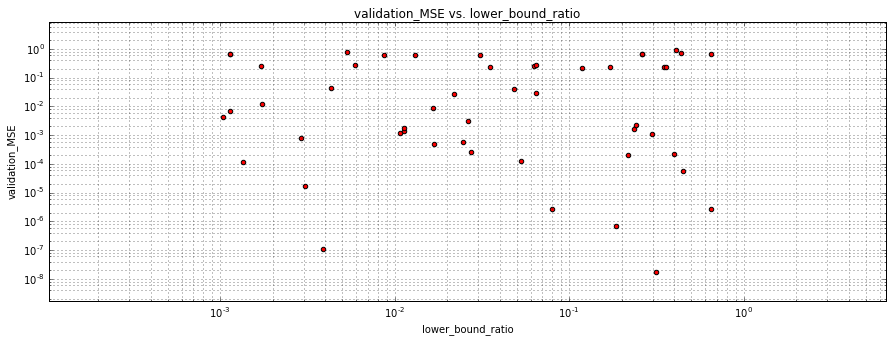

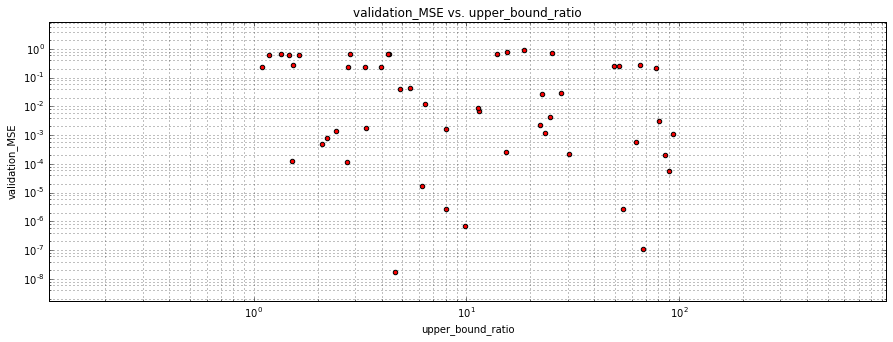

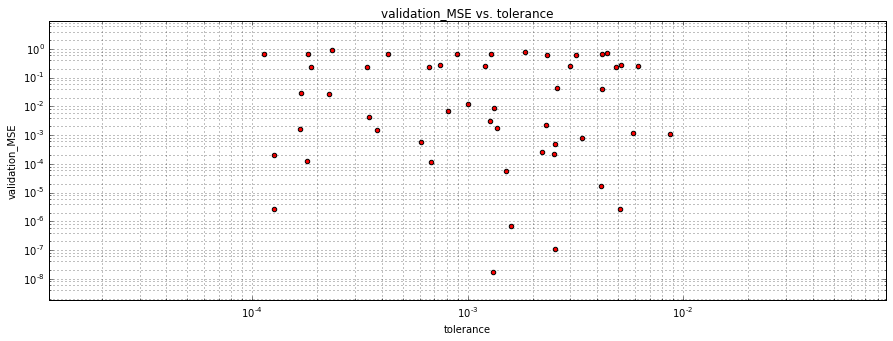

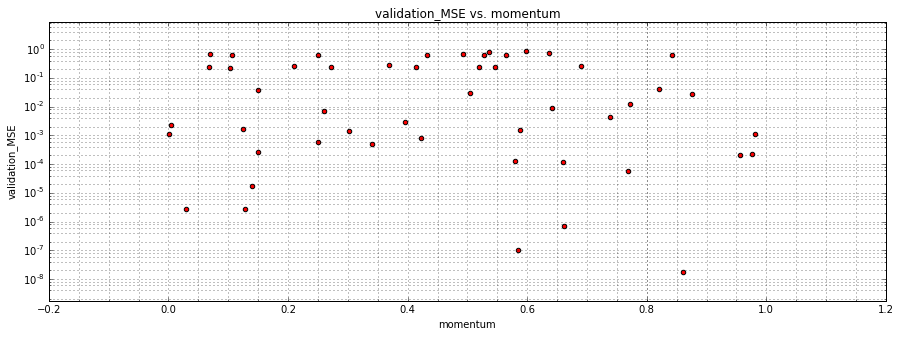

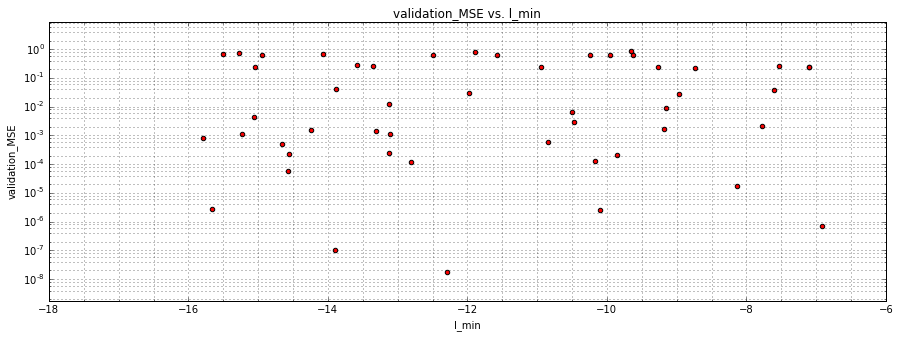

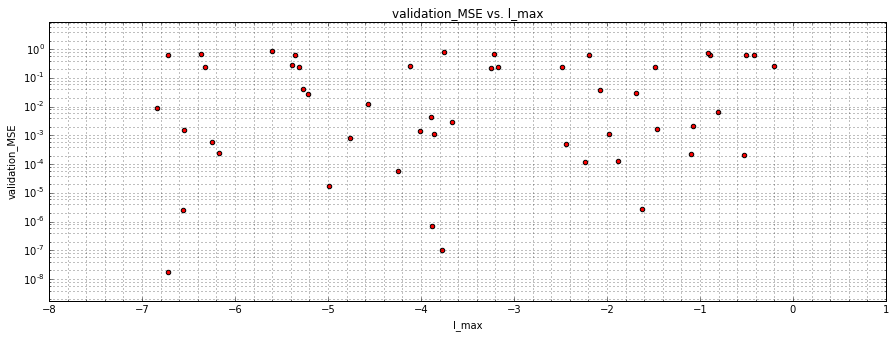

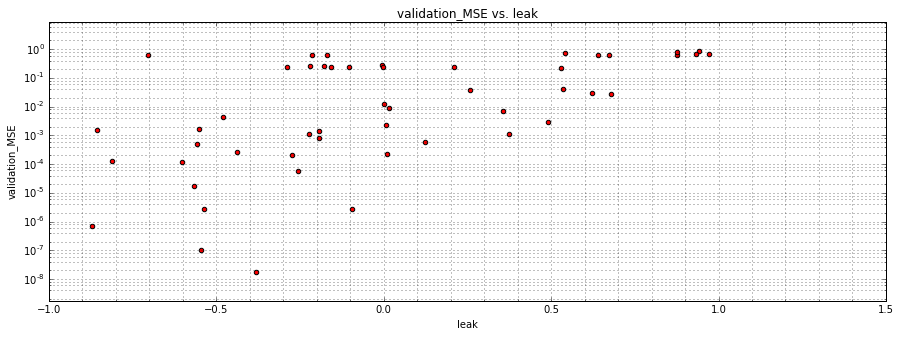

In [30]:
for hyperparam in 'lower_bound_ratio', 'upper_bound_ratio', 'tolerance':
    plotMSE(hyperparam)
    
for hyperparam in 'momentum', 'l_min', 'l_max', 'leak':
    plotMSE(hyperparam, log=False)

My interpretation of these plots is that, except the leaking factor, none of the hyper-parameters has individually a constraining effect on the MSE.

The last plot suggests that choosing a near-zero or positive value for the leaking factor has a detrimental effect. Values around $-0.5$ or smaller seem to work well, so it is safe to stay with the so far used value of $-1$ for future experiments.

As the leak had such a big effect, it may have suppressed some smaller effects of other parameters. Therefore I repeat this experiment with a constant leak of $-1$.

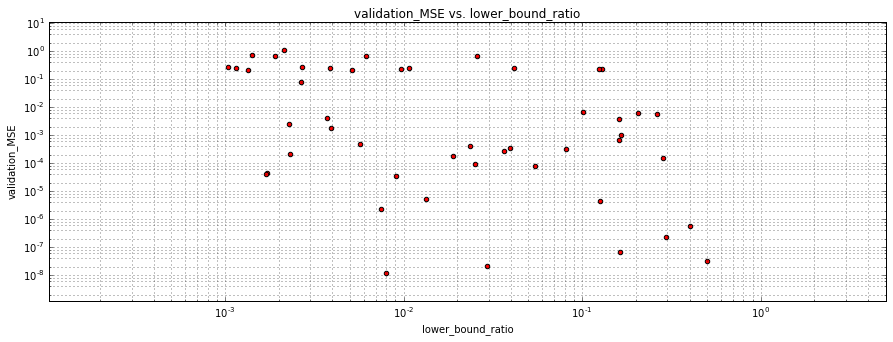

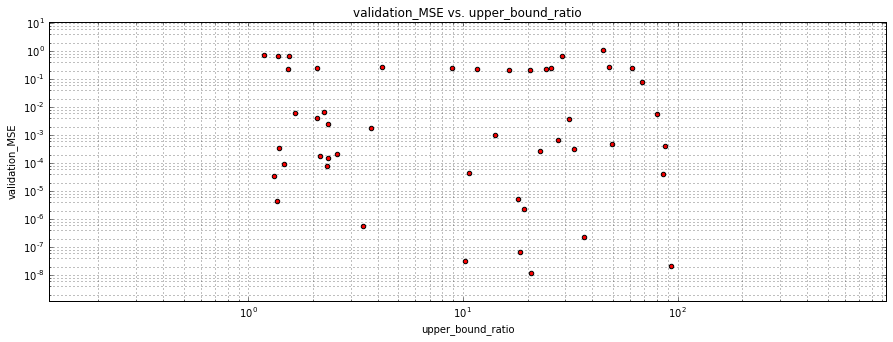

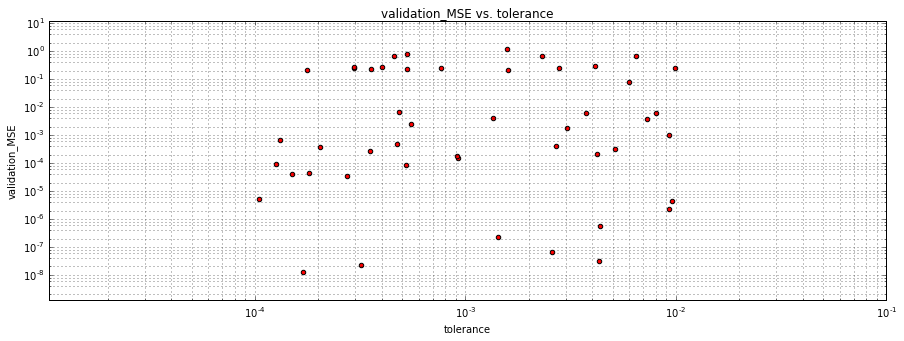

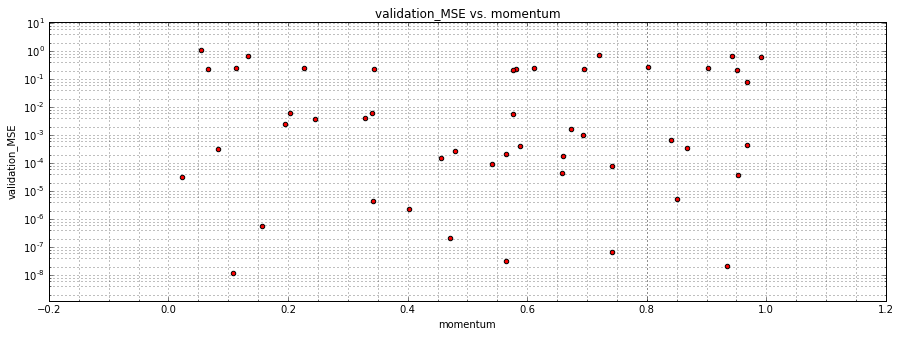

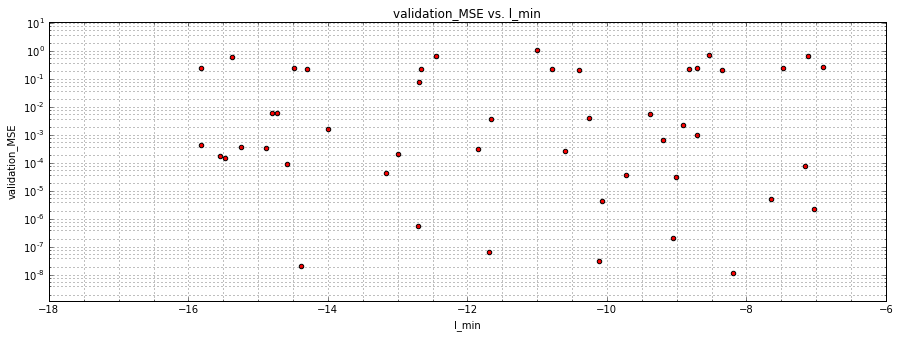

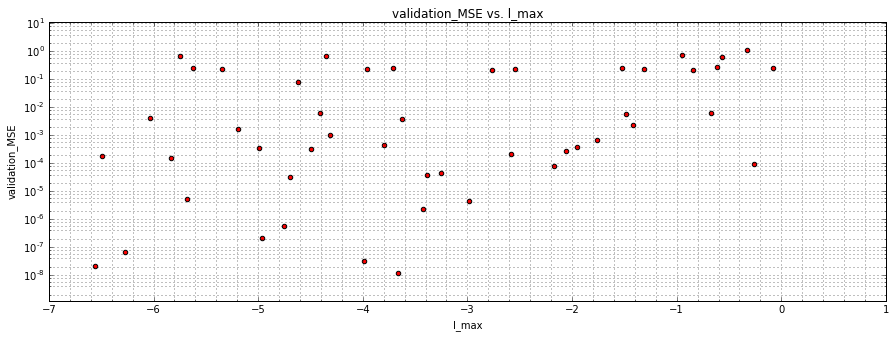

In [100]:
models, bad_models = createModels(graph, distributions)
for hyperparam in 'lower_bound_ratio', 'upper_bound_ratio', 'tolerance':
    plotMSE(hyperparam)
    
for hyperparam in 'momentum', 'l_min', 'l_max':
    plotMSE(hyperparam, log=False)

In [40]:
# Free up memory
del models[:]
del bad_models[:]

This repeated experiment suggests that the initial strength of the L-1 regularization has an impact on the MSE. For the diamond structure it should not be set to greater than $10^{-3}$. (However, this value is not necessarily transferable to models trained on other concurrency structures.)
#### What is the cause of the big variation in the MSE?
The MSE varies over 8 order of magnitude. If not the individual hyperparameters, then what is the cause of this huge variation?

I have these hypotheses:
1. The constellation of the individual hyper-parameters
2. The initialization of the weights of the neural network.
3. The order in which the data points of the trainig set are presented to the network.
4. Something else.

We can test these by 
1. Selecting the best of the above constellations and training a number of models with different initialization parameters.
2. Finding a good initialization and training a number of models with different hyper-parameters.
3. Traning multiple models with the best constellations and the same initialization.

The initialization is controlled through the seed of the random number generator. 

In [27]:
def createModelsSameConstellation(graph, num_models=50, training_steps_max=1500, seed=None, **paramsetting):
    bad_models = list()
    models = list()
    data = FSBSampler(graph, num_children=graph.num_children, 
                      training_set_size=5000, validation_set_size=5000, test_set_size=5000)
    for c in range(num_models):
        print "\n= Model #{} =".format(c)
        RNN = createNWayRNNLineSearch(graph.num_children, leaking_factor=-1, oversizing=1)
        rnn = RNN(MSE_limit=1e-8, training_steps_max=training_steps_max, **paramsetting)
        try:
            rnn.do_train(data=data, batch_size=128, rng=np.random.RandomState(seed), )
        except AssertionError as e:
            print "!!! NAN !!!"
            bad_models.append (rnn)
        else:
            models.append(rnn)
    return models, bad_models            

In [32]:
def plotRuns():
    plt.figure(figsize=(5, 5))
    plt.title('Validation MSE')
    plt.grid(which='both')
    plt.minorticks_on()
    x = range(len(models))
    y = [float(rnn.training_results['validation_MSE']) for rnn in models]
    plt.scatter(x, y, c='red')
    plt.yscale('log')
    plt.ylim(min(y)/10, max(y)*10)
    plt.xlim(-.5, len(x)+.5)
    plt.xlabel("Run")
    plt.ylabel("Validation MSE")
    plt.show()

##### Best constellation, varying initializations

In [16]:
models, bad_models = createModelsSameConstellation(graph, num_models=10,
        log_step_size_min=log(1e-7), log_step_size_max=log(1), 
        log_lower_bound_ratio=log(8e-3), log_upper_bound_ratio=log(20.), log_tolerance=log(1.7e-4), 
        momentum=0.1, l_min=-8.1, l_max=-3.6
    )

Generating 5000 training, 5000 validation and 5000 test samples using the following concurrency structure:

= Model #0 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-1.0000000	lambda_min = 0.0003035	lambda_max = 0.0273237
momentum = 0.1000000	training_steps_max = 1500.0000000
tolerance = 0.0001700,	lower_bound_ratio = 0.0080000	upper_bound_ratio = 20.0000000
Batch #0: lambda=0.000251, Cost=23.100377, MSE=23.098929, step_size=0.134002
#Steps = 1499 	Best training MSE = 0.101101716086 	Validation MSE = 0.323896249208

= Model #1 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-1.0000000	lambda_min = 0.0003035	lambda_max = 0.0273237
momentum = 0.1000000	training_steps_max = 1500.0000000
tolerance = 0.0001700,	lower_bound_ratio = 0.0080000	upper_bound_ratio = 20.0000000
Batch #0: lambda=0.000251, Cost=29.071083, MSE=29.069500, step_size=0.015437
#Steps = 1499 	Bes

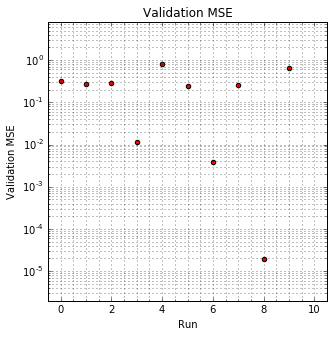

In [25]:
plotRuns()

The MSE varies inspite of the hyper-parameters being constant over the 10 runs with different initialization of the weights. 

##### Best constellation, same initialization
First we seek a good initialisation by varying the seed. 

In [30]:
for seed in range(100):
    models, bad_models = createModelsSameConstellation(graph, num_models=1, seed=seed,
        log_step_size_min=log(1e-7), log_step_size_max=log(1), 
        log_lower_bound_ratio=log(8e-3), log_upper_bound_ratio=log(20.), log_tolerance=log(1.7e-4), 
        momentum=0.1, l_min=-8.1, l_max=-3.6
    )
    if len(models) and models[0].training_results['validation_MSE'] < 1e-4:
        break

Generating 5000 training, 5000 validation and 5000 test samples using the following concurrency structure:

= Model #0 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-1.0000000	lambda_min = 0.0003035	lambda_max = 0.0273237
momentum = 0.1000000	training_steps_max = 1500.0000000
tolerance = 0.0001700,	lower_bound_ratio = 0.0080000	upper_bound_ratio = 20.0000000
Batch #0: lambda=0.000251, Cost=26.879967, MSE=26.878814, step_size=0.222531
#Steps = 1499 	Best training MSE = 0.121646746566 	Validation MSE = 0.3077511757
Generating 5000 training, 5000 validation and 5000 test samples using the following concurrency structure:

= Model #0 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-1.0000000	lambda_min = 0.0003035	lambda_max = 0.0273237
momentum = 0.1000000	training_steps_max = 1500.0000000
tolerance = 0.0001700,	lower_bound_ratio = 0.0080000	upper_bound_ratio = 2

In [35]:
print seed

13


This seed value seems to be a fortunate one... ;-)

In [34]:
models, bad_models = createModelsSameConstellation(graph, num_models=20, seed=seed,
    log_step_size_min=log(1e-7), log_step_size_max=log(1), 
    log_lower_bound_ratio=log(8e-3), log_upper_bound_ratio=log(20.), log_tolerance=log(1.7e-4), 
    momentum=0.1, l_min=-8.1, l_max=-3.6
)

Generating 5000 training, 5000 validation and 5000 test samples using the following concurrency structure:

= Model #0 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-1.0000000	lambda_min = 0.0003035	lambda_max = 0.0273237
momentum = 0.1000000	training_steps_max = 1500.0000000
tolerance = 0.0001700,	lower_bound_ratio = 0.0080000	upper_bound_ratio = 20.0000000
Batch #0: lambda=0.000251, Cost=22.395181, MSE=22.394248, step_size=0.210403
#Steps = 1499 	Best training MSE = 0.266795508925 	Validation MSE = 0.838694647942

= Model #1 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-1.0000000	lambda_min = 0.0003035	lambda_max = 0.0273237
momentum = 0.1000000	training_steps_max = 1500.0000000
tolerance = 0.0001700,	lower_bound_ratio = 0.0080000	upper_bound_ratio = 20.0000000
Batch #0: lambda=0.000251, Cost=20.158173, MSE=20.157240, step_size=0.259100
#Steps = 1499 	Bes

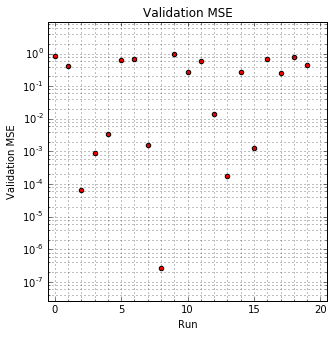

In [36]:
plotRuns()

13


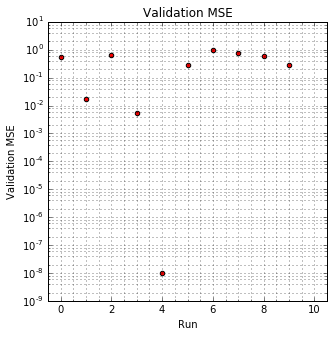

In [33]:
# another 10 runs
plotRuns()

The MSE varies inspite of the hyper-parameters and the initialization of the weights being constant over the 10 runs. This is a hint that even the order in which the data points are applied in the training makes a difference.

1500 iterations are not enough to cancel out the differences, be they caused by the hyper-parameters, weight-initialization or the order of data points.

##### Varying constellations, same initialization
to be completed

### Automated training on a larger concurrency structure

Does random search find good hyper-parameters for a structure of $15$ transactions?

The below function recursively builds a hieratchical concurrency structure.

In [31]:
def buildHierarchicalStructure(p):
    # choose the number of children
    numChildren = geom.rvs(p)
    # if 1 child, then create a TrxBp and return that
    if numChildren == 1:
        return Trx("trx")
    # else create a sub-hierarchy for each child
    children = list()
    pp = 1-(1-p)*(1-p)
    for _ in range(numChildren):
        child = buildHierarchicalStructure(pp)
        children.append(child)
    # choose an operator
    op = random.choice(operators)
    # join the sub-hierarchies using the operator
    return reduce(op, children)

operators = [operator.__or__, operator.__sub__]

In [32]:
buildHierarchicalStructure(0.4)

Trx('trx')

This function keeps building concurrency structures until it finds one with the desired number of child transactions.

In [57]:
def createGraph(p, num_children_min, num_children_max):
    while True:
        print '.',
        structure = buildHierarchicalStructure(p)
        graph = FSBGraph()
        graph.start_node, graph.end_node = structure.generate_graph(graph)
        if num_children_min <= graph.num_children <= num_children_max:
            print
            break
    pprint (structure)
    return graph

Let's create a structure of 15 transactions and train 50 models on it!

In [59]:
%%time
graph = createGraph(p=0.4, num_children_min=15, num_children_max=15 )
models, bad_models = createModels(graph, distributions, num_models=50, training_steps_max=1500)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
(Trx('trx') | Trx('trx') | (Trx('trx') - Trx('trx')) | Trx('trx') | Trx('trx') | Trx('trx') | Trx('trx') | (Trx('trx') - Trx('trx') - Trx('trx')) | Trx('trx') | Trx('trx') | (Trx('trx') - Trx('trx')))
Generating 5000 training, 5000 validation and 5000 test samples using the following concurrency structure:
= Model #0 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-1.0000000	lambda_min = 0.0000445	lambda_max = 0.0251576
momentum = 0.0322614	training_steps_max = 1500.0000000
tolerance = 0.0001961,	lower_bound_ratio = 0.0016375	upper_bound_ratio = 1.0524600
Batch #0: lambda=0.000208, Cost=46.487031, MSE=46.476865, step_size=0.014224
#Steps = 1499 	Best training MSE = 0.189207611259 	Validation MSE = 0.708908947332

= Model #1 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-1

The trainings lasted nearly 8 hours on a single core and 5 models ended with NAN.

None of the models reached such nice MSE values as could be reached for the diamond. Potential causes:
1. The search space was too small. This assumption contradicts to our previous experiment showing that none of the individual hyper-parameters had an extreme impact on the MSE.
2. All 50 runs had unfavorable initial settings of the weights of the network. The reasoning to support this is that the search space for the weights of a 15-way network are 9 times higher than that of the diamond structure, and 50 runs were not enough to sufficiently cover the larger space. However this reasoning also seems to be invalid. Extrapolating from the diamond structure, where $34$ of the $50$ runs had $MSE < 10^{-1}$, the expected number of such runs on the current structure is around $34:9=3.7$, so finding none is strange!
3. For some other reasons this 15-transaction hierarchical structure is much more difficult to learn.

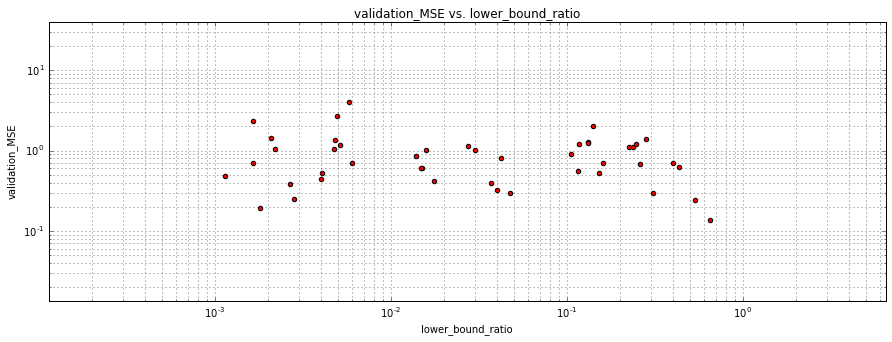

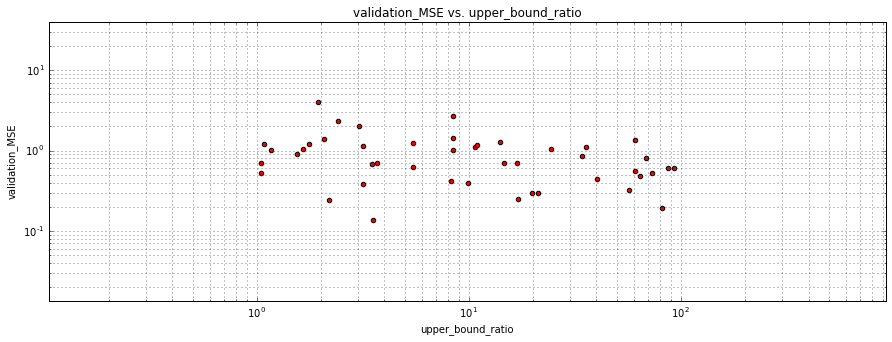

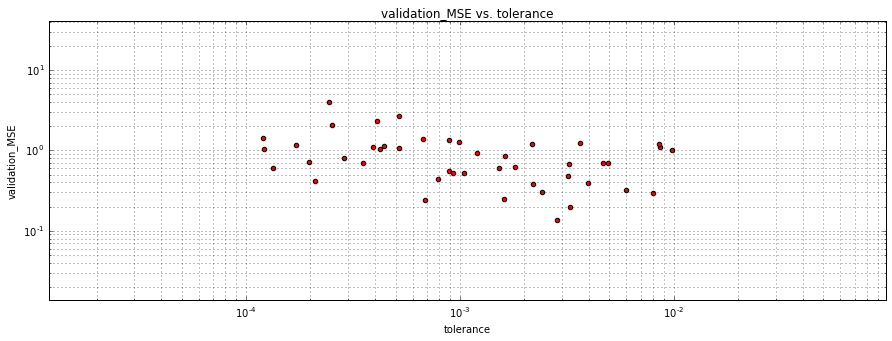

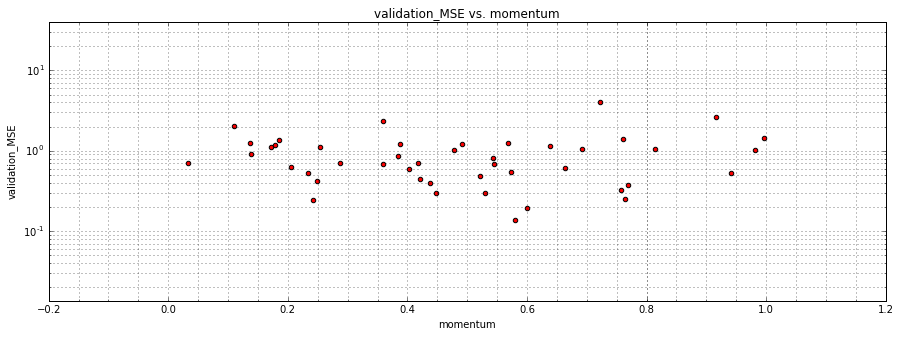

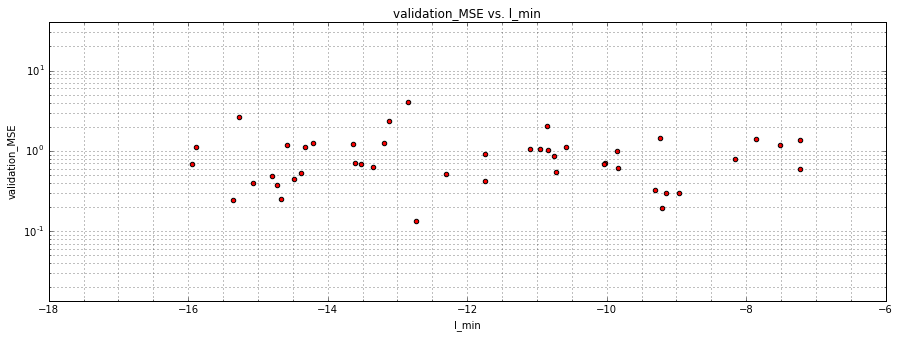

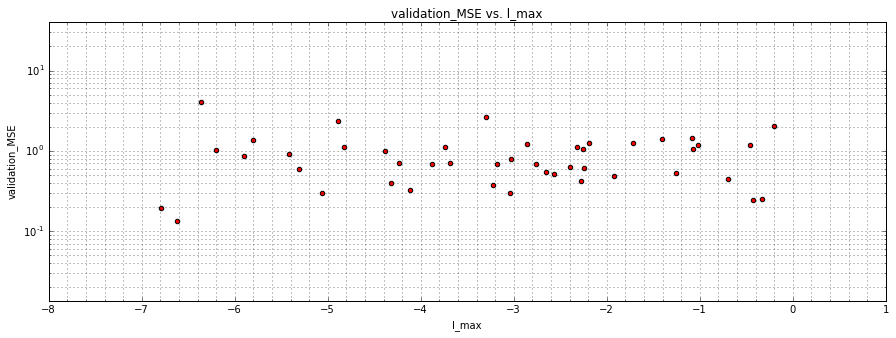

In [60]:
for hyperparam in 'lower_bound_ratio', 'upper_bound_ratio', 'tolerance':
    plotMSE(hyperparam)
    
for hyperparam in 'momentum', 'l_min', 'l_max':
    plotMSE(hyperparam, log=False)

In [61]:
# Free up memory
del models[:]
del bad_models[:]

In [58]:
def trainModels4Graphs(num_graphs, num_children_min, num_children_max, num_models, training_steps_max):
    graphs = list()
    for i in range(num_graphs):
        print "\n=== Graph #{} ===".format(i)
        graph = createGraph(p=0.4, num_children_min=num_children_min, num_children_max=num_children_max, )
        models, bad_models = createModels(graph, distributions, num_models=num_models, 
                                          training_steps_max=training_steps_max)

        graph.best_model = min(models, key=lambda rnn: rnn.training_results['validation_MSE'])
        print "Best model's validation MSE: {}".format(graph.best_model.training_results['validation_MSE'])
        graphs.append(graph)
    return graphs

In [52]:
%%time
graphs = trainModels4Graphs(num_graphs=50, num_children_min=6, num_children_max=15, 
                            num_models=10, training_steps_max=1500)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

=== Graph #0 ===
(Trx('trx') | Trx('trx') | Trx('trx') | Trx('trx') | Trx('trx') | (Trx('trx') - Trx('trx')) | Trx('trx') | Trx('trx') | Trx('trx') | (Trx('trx') - Trx('trx') - Trx('trx') - Trx('trx') - Trx('trx')))
Generating 5000 training, 5000 validation and 5000 test samples using the following concurrency structure:
= Model #0 =
Creating NWayRNNLineSearch
Created NWayRNNLineSearch
Training the model using the following parameters:
leak=-1.0000000	lambda_min = 0.0000274	lambda_max = 0.0349380
momentum = 0.0082998	training_steps_max = 1500.0000000
tolerance = 0.0006079,	lower_bound_ratio = 0.0031724	upper_bound_ratio = 4.7798737
Batch #0: lambda=0.000442, Cost=68.614360, MSE=68.591462, step_size=0.020398


KeyboardInterrupt: 